<a href="https://colab.research.google.com/github/jlee1998/Advanced-Project-in-Mathematics/blob/main/Kernel_Brusselator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from google.colab import files
import argparse
import matplotlib
import matplotlib.pyplot as plt
import torch
import tqdm
import numpy as np
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split
import os
from matplotlib import cm
import cmath
from scipy import special


## Preprocessing

In [1]:
pip install git+https://github.com/rtqichen/torchdiffeq/

  Cloning https://github.com/rtqichen/torchdiffeq/ to /tmp/pip-req-build-fdndt221
  Running command git clone -q https://github.com/rtqichen/torchdiffeq/ /tmp/pip-req-build-fdndt221
  Created wheel for torchdiffeq: filename=torchdiffeq-0.2.1-cp37-none-any.whl size=31204 sha256=ced077351a6ae737bc96f00f8b6db8672d9605ec502f833408c55df0faedda61
  Stored in directory: /tmp/pip-ephem-wheel-cache-3opzyvl7/wheels/19/a0/ee/5623ea3a96376e4f2d6f949fd04d6287ff8f8b0c30fafbdc0b
Successfully built torchdiffeq


In [ ]:
class ODE_Dataset(Dataset):
    """
    Dataset class for ODE type of data. With 2 values.
    Can be fed with either a csv file containg the dataframe or directly with a panda dataframe.
    One can further provide samples idx that will be used (for training / validation split purposes.)
    """
    def __init__(self, csv_file=None, cov_file=None, label_file=None, panda_df=None, cov_df=None, label_df=None, root_dir="./", t_mult=1.0, idx=None, jitter_time=0, validation = False, val_options = None):
        """
        Args:
            csv_file   CSV file to load the dataset from
            panda_df   alternatively use pandas df instead of CSV file
            root_dir   directory of the CSV file
            t_mult     multiplier for time values (1.0 default)
            jitter_time  jitter size (0 means no jitter), to add randomly to Time.
                         Jitter is added before multiplying with t_mult
            validation boolean. True if this dataset is for validation purposes
            val_options  dictionnary with validation dataset options.
                                    T_val : Time after which observations are considered as test samples
                                    max_val_samples : maximum number of test observations per trajectory.

        """
        self.validation = validation

        if panda_df is not None:
            assert (csv_file is None), "Only one feeding option should be provided, not both"
            self.df = panda_df
            self.cov_df = cov_df
            self.label_df  = label_df
        else:
            assert (csv_file is not None) , "At least one feeding option required !"
            self.df = pd.read_csv(root_dir + "/" + csv_file)
            assert self.df.columns[0]=="ID"
            if label_file is None:
                self.label_df = None
            else:
                self.label_df = pd.read_csv(root_dir + "/" + label_file)
                assert self.label_df.columns[0]=="ID"
                assert self.label_df.columns[1]=="label"
            if cov_file is None :
                self.cov_df = None
            else:
                self.cov_df = pd.read_csv(root_dir + "/" + cov_file)
                assert self.cov_df.columns[0]=="ID"

        #Create Dummy covariates and labels if they are not fed.
        if self.cov_df is None:
            num_unique = np.zeros(self.df["ID"].nunique())
            self.cov_df = pd.DataFrame({"ID":self.df["ID"].unique(),"Cov": num_unique})
        if self.label_df is None:
            num_unique = np.zeros(self.df["ID"].nunique())
            self.label_df = pd.DataFrame({"ID":self.df["ID"].unique(),"label": num_unique})

        #If validation : consider only the data with a least one observation before T_val and one observation after:
        self.store_last = False
        if self.validation:
            df_beforeIdx = self.df.loc[self.df["Time"]<=val_options["T_val"],"ID"].unique()
            if val_options.get("T_val_from"): #Validation samples only after some time.
                df_afterIdx  = self.df.loc[self.df["Time"]>=val_options["T_val_from"],"ID"].unique()
                self.store_last = True #Dataset get will return a flag for the collate to compute the last sample before T_val
            else:
                df_afterIdx  = self.df.loc[self.df["Time"]>val_options["T_val"],"ID"].unique()
            
            valid_idx = np.intersect1d(df_beforeIdx,df_afterIdx)
            self.df = self.df.loc[self.df["ID"].isin(valid_idx)]
            self.label_df = self.label_df.loc[self.label_df["ID"].isin(valid_idx)]
            self.cov_df   = self.cov_df.loc[self.cov_df["ID"].isin(valid_idx)]

        if idx is not None:
            self.df = self.df.loc[self.df["ID"].isin(idx)].copy()
            map_dict= dict(zip(self.df["ID"].unique(),np.arange(self.df["ID"].nunique())))
            self.df["ID"] = self.df["ID"].map(map_dict) # Reset the ID index.

            self.cov_df = self.cov_df.loc[self.cov_df["ID"].isin(idx)].copy()
            self.cov_df["ID"] = self.cov_df["ID"].map(map_dict) # Reset the ID index.

            self.label_df = self.label_df.loc[self.label_df["ID"].isin(idx)].copy()
            self.label_df["ID"] = self.label_df["ID"].map(map_dict) # Reset the ID index.


        assert self.cov_df.shape[0]==self.df["ID"].nunique()

        self.variable_num = sum([c.startswith("Phi") for c in self.df.columns]) #number of variables in the dataset
        self.cov_dim = self.cov_df.shape[1]-1

        self.cov_df = self.cov_df.astype(np.float32)
        self.cov_df.set_index("ID", inplace=True)

        self.label_df.set_index("ID",inplace=True)

        self.df.Time    = self.df.Time * t_mult

        #TO DO : make jitter compatible with several variables
        if jitter_time != 0:
            self.df = add_jitter(self.df, jitter_time=jitter_time)
            self.df.Value_1 = self.df.Value_1.astype(np.float32)
            self.df.Value_2 = self.df.Value_2.astype(np.float32)
            self.df.Mask_1  = self.df.Mask_1.astype(np.float32)
            self.df.Mask_2  = self.df.Mask_2.astype(np.float32)

        else:
            self.df = self.df.astype(np.float32)

        if self.validation:
            assert val_options is not None, "Validation set options should be fed"
            self.df_before = self.df.loc[self.df["Time"]<=val_options["T_val"]].copy()
            if val_options.get("T_val_from"): #Validation samples only after some time.
                self.df_after  = self.df.loc[self.df["Time"]>=val_options["T_val_from"]].sort_values("Time").copy()
            else:
                self.df_after  = self.df.loc[self.df["Time"]>val_options["T_val"]].sort_values("Time").copy()

            if val_options.get("T_closest") is not None:
                df_after_temp = self.df_after.copy()
                df_after_temp["Time_from_target"] = (df_after_temp["Time"]-val_options["T_closest"]).abs()
                df_after_temp.sort_values(by=["Time_from_target","Value_0"], inplace = True,ascending=True)
                df_after_temp.drop_duplicates(subset=["ID"],keep="first",inplace = True)
                self.df_after = df_after_temp.drop(columns = ["Time_from_target"])
            else:
                self.df_after  = self.df_after.groupby("ID").head(val_options["max_val_samples"]).copy()

            self.df = self.df_before #We remove observations after T_val


            self.df_after.ID = self.df_after.ID.astype(np.int)
            self.df_after.sort_values("Time", inplace=True)
        else:
            self.df_after = None


        self.length     = self.df["ID"].nunique()
        self.df.ID      = self.df.ID.astype(np.int)
        self.df.set_index("ID", inplace=True)

        self.df.sort_values("Time", inplace=True)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        subset = self.df.loc[idx]
        if len(subset.shape)==1: #Don't ask me anything about this.
            subset = self.df.loc[[idx]]

        covs = self.cov_df.loc[idx].values
        tag  = self.label_df.loc[idx].astype(np.float32).values
        if self.validation :
            val_samples = self.df_after.loc[self.df_after["ID"]==idx]
        else:
            val_samples = None
        ## returning also idx to allow empty samples
        return {"idx":idx, "y": tag, "path": subset, "cov": covs , "val_samples":val_samples, "store_last":self.store_last}

def add_jitter(df, jitter_time=1e-3):
    """Modifies Double OU dataset, so that observations with both dimensions
       are split. One is randomly shifted earlier by amount 'jitter_time'.
    """
    if df.columns.shape[0] != 6:
        raise ValueError("Only df with 6 columns: supports 2 value and 2 mask columns.")

    both = (df["Mask_1"] == 1.0) & (df["Mask_2"] == 1.0)
    df_single = df[both == False]
    df_both   = df[both]
    df_both1  = df_both.copy()
    df_both2  = df_both.copy()

    df_both1["Mask_2"] = 0.0
    df_both2["Mask_1"] = 0.0
    jitter = np.random.randint(2, size=df_both1.shape[0])
    df_both1["Time"] -= jitter_time * jitter
    df_both2["Time"] -= jitter_time * (1 - jitter)

    df_jit = pd.concat([df_single, df_both1, df_both2])
    ## make sure time is not negative:
    df_jit.Time.clip_lower(0.0, inplace=True)
    return df_jit



def custom_collate_fn(batch):
    idx2batch = pd.Series(np.arange(len(batch)), index = [b["idx"] for b in batch])

    pat_idx   = [b["idx"] for b in batch]
    df        = pd.concat([b["path"] for b in batch],axis=0)
    df.sort_values(by=["Time"], inplace=True)

    df_cov    = torch.Tensor([b["cov"] for b in batch])

    labels  = torch.tensor([b["y"] for b in batch])

    batch_ids     = idx2batch[df.index.values].values

    ## calculating number of events at every time
    times, counts = np.unique(df.Time.values, return_counts=True)
    time_ptr      = np.concatenate([[0], np.cumsum(counts)])

    ## tensors for the data in the batch
    value_cols = [c.startswith("Value") for c in df.columns]
    phi_cols = [c.startswith("Phi") for c in df.columns]
    mask_cols  = [c.startswith("Mask") for c in df.columns]

    if batch[0]['val_samples'] is not None:
        df_after = pd.concat(b["val_samples"] for b in batch)
        df_after.sort_values(by=["ID","Time"], inplace=True)
        value_cols_val = [c.startswith("Value") for c in df_after.columns]
        phi_cols_val = [c.startswith("Phi") for c in df_after.columns]
        mask_cols_val  = [c.startswith("Mask") for c in df_after.columns]
        X_val = torch.tensor(df_after.iloc[:,value_cols_val].values)
        Phi_val = torch.tensor(df_after.iloc[:,phi_cols_val].values)
        M_val = torch.tensor(df_after.iloc[:,mask_cols_val].values)
        times_val = df_after["Time"].values
        index_val = idx2batch[df_after["ID"].values].values

        # Last observation before the T_val cut_off. THIS IS LIKELY TO GIVE ERRORS IF THE NUMBER OF VALIDATION SAMPLES IS HIGHER THAN 2. CHECK THIS.
        if batch[0]["store_last"]:
            df_last = df[~df.index.duplicated(keep="last")].copy()
            index_last = idx2batch[df_last.index.values].values
        
            perm_last = sort_array_on_other(index_val,index_last)
            tens_last = torch.tensor(df_last.iloc[:,value_cols].values[perm_last,:])
            index_last = index_last[perm_last]
        else:
            index_last = 0
            tens_last = 0
    else:
        X_val = None
        M_val = None
        Phi_val = None
        times_val = None
        index_val = None
        tens_last = None
        index_last = None


    res = {}
    res["pat_idx"]  = pat_idx
    res["times"]    = times
    res["time_ptr"] = time_ptr
    res["X"]        = torch.tensor(df.iloc[:, value_cols].values)
    res["M"]        = torch.tensor(df.iloc[:, mask_cols].values)
    res["Phi"]        = torch.tensor(df.iloc[:, phi_cols].values)
    res["obs_idx"]  = torch.tensor(batch_ids)
    res["y"]        = labels
    res["cov"]      = df_cov
    res["X_val"]    = X_val
    res["M_val"]    = M_val
    res["Phi_val"]  = Phi_val
    res["times_val"]= times_val
    res["index_val"]= index_val
    res["X_last"]   = tens_last
    res["obs_idx_last"]= index_last

    return res

def seq_collate_fn(batch):
    """
    Returns several tensors. Tensor of lengths should not be sent to CUDA.
    """
    idx2batch  = pd.Series(np.arange(len(batch)), index = [b["idx"] for b in batch])
    df         = pd.concat(b["path"] for b in batch)
    value_cols = [c.startswith("Value") for c in df.columns]
    phi_cols = [c.startswith("Phi") for c in df.columns]
    mask_cols  = [c.startswith("Mask") for c in df.columns]

    ## converting mask to int
    df.iloc[:, mask_cols] = df.iloc[:, mask_cols].astype(np.bool)
    df["num_obs"]         = -df.iloc[:,mask_cols].sum(1)
    df.sort_values(by=["Time", "num_obs"], inplace=True)

    ## num_obs is not a value/mask column
    value_cols.append(False)
    phi_cols.append(False)
    mask_cols.append(False)

    cov = torch.Tensor([b["cov"] for b in batch])

    batch_ids = idx2batch[df.index.values].values

    ## calculating number of events at every time
    times, counts = np.unique(df.Time.values, return_counts=True)
    time_ptr      = np.concatenate([[0], np.cumsum(counts)])
    assert df.shape[0] == time_ptr[-1]

    ## tensors for the data in the batch
    X = df.iloc[:, value_cols].values
    Phi = df.iloc[:, phi_cols].values
    M = df.iloc[:, mask_cols].values

    ## selecting only observed X and splitting
    lengths = (-df.num_obs.values).tolist()
    Xsplit  = torch.split(torch.from_numpy(X[M]), lengths)    
    Phisplit  = torch.split(torch.from_numpy(Phi[M]), lengths)
    Fsplit  = torch.split(torch.from_numpy(np.where(M)[1]), lengths)

    Xpadded = torch.nn.utils.rnn.pad_sequence(Xsplit, batch_first=True)
    Phipadded = torch.nn.utils.rnn.pad_sequence(Phisplit, batch_first=True)
    Fpadded = torch.nn.utils.rnn.pad_sequence(Fsplit, batch_first=True)

    if batch[0]['val_samples'] is not None:
        df_after = pd.concat(b["val_samples"] for b in batch)
        df_after.sort_values(by=["ID","Time"], inplace=True)
        value_cols_val = [c.startswith("Value") for c in df_after.columns]
        mask_cols_val  = [c.startswith("Mask") for c in df_after.columns]
        phi_cols_val  = [c.startswith("Phi") for c in df_after.columns]
        X_val = torch.tensor(df_after.iloc[:,value_cols_val].values)
        M_val = torch.tensor(df_after.iloc[:,mask_cols_val].values)
        Phi_val = torch.tensor(df_after.iloc[:,phi_cols_val].values)
        times_val = df_after["Time"].values
        index_val = idx2batch[df_after["ID"].values].values
    else:
        X_val = None
        M_val = None
        Phi_val = None
        times_val = None
        index_val = None

    res = {}
    res["times"]    = times
    res["time_ptr"] = time_ptr
    res["Xpadded"]  = Xpadded
    res["Fpadded"]  = Fpadded
    res["X"]        = torch.from_numpy(X)
    res["M"]        = torch.from_numpy(M.astype(np.float32))
    res["Phi"]        = torch.from_numpy(Phi)
    res["lengths"]  = torch.LongTensor(lengths)
    res["obs_idx"]  = torch.tensor(batch_ids)
    res["y"]        = torch.tensor([b["y"] for b in batch])
    res["cov"]      = cov
    res["X_val"]    = X_val
    res["M_val"]    = M_val
    res["Phi_val"]    = Phi_val
    res["times_val"]=times_val
    res["index_val"]=index_val

    return res


def extract_from_path(t_vec, p_vec, eval_times, path_idx_eval):
    '''
    Takes :
    t_vec : numpy vector of absolute times length [T]. Should be ordered.
    p_vec : numpy array of means and logvars of a trajectory at times t_vec. [T x batch_size x (2xfeatures)]
    eval_times : numpy vector of absolute times at which we want to retrieve p_vec. [L]
    path_idx_eval : index of trajectory that we want to retrieve. Should be same length of eval_times. [L]
    Returns :
    Array of dimensions [L,(2xfeatures)] of means and logvar of the required eval times and trajectories
    '''
    #Remove the evaluation after the updates. Only takes the prediction before the Bayesian update. 
    t_vec, unique_index = np.unique(t_vec,return_index=True)
    p_vec = p_vec[unique_index,:,:]

    present_mask = np.isin(eval_times, t_vec)
    eval_times[~present_mask] = map_to_closest(eval_times[~present_mask],t_vec)

    mapping = dict(zip(t_vec,np.arange(t_vec.shape[0])))

    time_idx = np.vectorize(mapping.get)(eval_times)

    return(p_vec[time_idx,path_idx_eval,:])

def map_to_closest(input,reference):
    output = np.zeros_like(input)
    for idx, element in enumerate(input):
        closest_idx=(np.abs(reference-element)).argmin()
        output[idx]=reference[closest_idx]
    return(output)

def adjust_learning_rate(optimizer, epoch, init_lr):
    if epoch > 20:
        for param_group in optimizer.param_groups:
            param_group["lr"] = init_lr/3
            
def compute_corr(X_true, X_hat, Mask):
    means_true = X_true.sum(0)/Mask.sum(0)
    means_hat  = X_hat.sum(0)/Mask.sum(0)
    corr_num = ((X_true-means_true)*(X_hat-means_hat)*Mask).sum(0)
    corr_denum1 = ((X_true-means_true).pow(2)*Mask).sum(0).sqrt()
    corr_denum2 = ((X_hat-means_hat).pow(2)*Mask).sum(0).sqrt()
    return corr_num/(corr_denum1*corr_denum2)


def sort_array_on_other(x1,x2):
    """
    This function returns the permutation y needed to transform x2 in x1 s.t. x2[y]=x1
    """

    temp_dict = dict(zip(x1,np.arange(len(x1))))
    index = np.vectorize(temp_dict.get)(x2)
    perm = np.argsort(index)

    assert((x2[perm]==x1).all())

    return(perm)

def log_lik_gaussian(x,mu,logvar):
    return np.log(np.sqrt(2*np.pi)) + (logvar/2) + ((x-mu).pow(2)/(2*logvar.exp()))

def tail_fun_gaussian(x,mu,logvar):
    """
    Returns the probability that the given distribution is HIGHER than x.
    """
    return 0.5-0.5*special.erf((x-mu)/((0.5*logvar).exp()*np.sqrt(2)))


In [ ]:
import torch
import math
import numpy as np
from torchdiffeq import odeint
import sklearn
from sklearn.decomposition import KernelPCA
KPCA=sklearn.decomposition.KernelPCA(n_components=2, kernel='poly', gamma=2, kernel_params=None, alpha=1.0, fit_inverse_transform=True, eigen_solver='auto', tol=0, max_iter=None, remove_zero_eig=False, random_state=None, copy_X=True, n_jobs=None)
from torch.nn.utils.rnn import pack_padded_sequence

# GRU-ODE: Neural Negative Feedback ODE with Bayesian jumps


class FullGRUODECell(torch.nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        """
        For p(t) modelling input_size should be 2x the x size.
        """
        super().__init__()

        #self.lin_xh = torch.nn.Linear(input_size, hidden_size, bias=bias)
        #self.lin_xz = torch.nn.Linear(input_size, hidden_size, bias=bias)
        #self.lin_xr = torch.nn.Linear(input_size, hidden_size, bias=bias)

        self.lin_x = torch.nn.Linear(input_size, hidden_size * 3, bias=bias)

        self.lin_hh = torch.nn.Linear(hidden_size, hidden_size, bias=False)
        self.lin_hz = torch.nn.Linear(hidden_size, hidden_size, bias=False)
        self.lin_hr = torch.nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, x, h):
        """
        Executes one step with GRU-ODE for all h.
        The step size is given by delta_t.

        Args:
            x        input values
            h        hidden state (current)
            delta_t  time step

        Returns:
            Updated h
        """
        xr, xz, xh = torch.chunk(self.lin_x(x), 3, dim=1)
        r = torch.sigmoid(xr + self.lin_hr(h))
        z = torch.sigmoid(xz + self.lin_hz(h))
        u = torch.tanh(xh + self.lin_hh(r * h))

        dh = (1 - z) * (u - h)
        return dh

class GRUObservationCellLogvar(torch.nn.Module):
    """Implements discrete update based on the received observations."""

    def __init__(self, input_size, hidden_size, prep_hidden, bias=True):
        super().__init__()
        self.gru_d     = torch.nn.GRUCell(prep_hidden * input_size, hidden_size, bias=bias)
        self.gru_debug = torch.nn.GRUCell(prep_hidden * input_size, hidden_size, bias=bias)

        ## prep layer and its initialization
        std            = math.sqrt(2.0 / (4 + prep_hidden))
        self.w_prep    = torch.nn.Parameter(std * torch.randn(input_size, 4, prep_hidden))
        self.bias_prep = torch.nn.Parameter(0.1 + torch.zeros(input_size, prep_hidden))

        self.input_size  = input_size
        self.prep_hidden = prep_hidden

    def forward(self, h, p, X_obs,Phi_obs, M_obs, i_obs):
        ## only updating rows that have observations
        p_obs        = p[i_obs]


        mean, logvar = torch.chunk(p_obs, 2, dim=1)
        #mean2 = torch.from_numpy(KPCA.fit_transform(mean.cpu().detach().numpy())).cuda()
        #logvar2 = torch.from_numpy(KPCA.fit_transform(logvar.cpu().detach().numpy())).cuda()
        
        sigma        = torch.exp(0.5 * logvar)
        error        = (Phi_obs - mean) / sigma

        ## log normal loss, over all observations
        log_lik_c    = np.log(np.sqrt(2*np.pi))
        #losses       = 0.5 * ((torch.pow(error, 2) + logvar + 2*log_lik_c) * M_obs)
        losses       = 0.5 * ((torch.pow(error, 2) + logvar + 2*log_lik_c))
        if losses.sum()!=losses.sum():
            import ipdb; ipdb.set_trace()
        ## TODO: try removing X_obs (they are included in error)
        gru_input    = torch.stack([Phi_obs,mean, logvar, error], dim=2).unsqueeze(2)
        gru_input    = torch.matmul(gru_input, self.w_prep).squeeze(2) + self.bias_prep
        gru_input.relu_()
        ## gru_input is (sample x feature x prep_hidden)
        gru_input    = gru_input.permute(2, 0, 1)
        #gru_input    = (gru_input*M_obs).permute(1, 2, 0).contiguous().view(-1, self.prep_hidden * self.input_size)
        gru_input    = (gru_input).permute(1, 2, 0).contiguous().view(-1, self.prep_hidden * self.input_size)

        temp = h.clone()
        temp[i_obs] = self.gru_d(gru_input, h[i_obs])
        h = temp

        return h, losses



def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.05)

class NNFOwithBayesianJumps(torch.nn.Module):
    ## Neural Negative Feedback ODE with Bayesian jumps
    def __init__(self, input_size, hidden_size, p_hidden, prep_hidden, bias=True, cov_size=1, cov_hidden=1, classification_hidden=1, logvar=True, mixing=1, dropout_rate=0, full_gru_ode=False, solver="euler", impute = True, **options):
        """
        The smoother variable computes the classification loss as a weighted average of the projection of the latents at each observation.
        impute feeds the parameters of the distribution to GRU-ODE at each step.
        """

        super().__init__()

        self.impute = impute
        self.p_model = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, p_hidden, bias=bias),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout_rate),
            torch.nn.Linear(p_hidden, 2 * input_size, bias=bias),
        )

        self.classification_model = torch.nn.Sequential(
            torch.nn.Linear(hidden_size,classification_hidden,bias=bias),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout_rate),
            torch.nn.Linear(classification_hidden,1,bias=bias)
        )
        if full_gru_ode:
            if impute is False:
                self.gru_c   = FullGRUODECell_Autonomous(hidden_size, bias = bias)
            else:
                self.gru_c   = FullGRUODECell(2 * input_size, hidden_size, bias=bias)

        else:
            if impute is False:
                self.gru_c = GRUODECell_Autonomous(hidden_size, bias= bias)
            else:
                self.gru_c   = GRUODECell(2 * input_size, hidden_size, bias=bias)

        if logvar:
            self.gru_obs = GRUObservationCellLogvar(input_size, hidden_size, prep_hidden, bias=bias)
        else:
            self.gru_obs = GRUObservationCell(input_size, hidden_size, prep_hidden, bias=bias)

        self.covariates_map = torch.nn.Sequential(
            torch.nn.Linear(cov_size, cov_hidden, bias=bias),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout_rate),
            torch.nn.Linear(cov_hidden, hidden_size, bias=bias),
            torch.nn.Tanh()
        )

        assert solver in ["euler", "midpoint", "dopri5"], "Solver must be either 'euler' or 'midpoint' or 'dopri5'."

        self.solver     = solver
        self.store_hist = options.pop("store_hist",False)
        self.input_size = input_size
        self.logvar     = logvar
        self.mixing     = mixing #mixing hyperparameter for loss_1 and loss_2 aggregation.

        self.apply(init_weights)

    def ode_step(self, h, p, delta_t, current_time):
        """Executes a single ODE step."""
        eval_times = torch.tensor([0],device = h.device, dtype = torch.float64)
        eval_ps = torch.tensor([0],device = h.device, dtype = torch.float32)
        if self.impute is False:
            p = torch.zeros_like(p)
            
        if self.solver == "euler":
            h = h + delta_t * self.gru_c(p, h)
            #add noise
            #dW=0.1*delta_t*torch.normal(mean=0,std=torch.ones((20*h.size()[0],1))).reshape(h.size()[0],20).cuda()
            #h= h.add(dW)
            p = self.p_model(h)

        elif self.solver == "midpoint":
            k  = h + delta_t / 2 * self.gru_c(p, h)
            pk = self.p_model(k)

            h = h + delta_t * self.gru_c(pk, k)
            p = self.p_model(h)

        elif self.solver == "dopri5":
            assert self.impute==False #Dopri5 solver is only compatible with autonomous ODE.
            solution, eval_times, eval_vals = odeint(self.gru_c,h,torch.tensor([0,delta_t]),method=self.solver,options={"store_hist":self.store_hist})
            if self.store_hist:
                eval_ps = self.p_model(torch.stack([ev[0] for ev in eval_vals]))
            eval_times = torch.stack(eval_times) + current_time
            h = solution[1,:,:]
            p = self.p_model(h)
        
        current_time += delta_t
        return h,p,current_time, eval_times, eval_ps

        raise ValueError(f"Unknown solver '{self.solver}'.")

    def forward(self, times, time_ptr, X, Phi, M, obs_idx, delta_t, T, cov,return_path=False, smoother = False, class_criterion = None, labels=None):
        """
        Args:
            times      np vector of observation times
            time_ptr   start indices of data for a given time
            X          original data tensor
            Phi        RKHS data tensor
            M          mask tensor (1.0 if observed, 0.0 if unobserved)
            obs_idx    observed patients of each datapoint (indexed within the current minibatch)
            delta_t    time step for Euler
            T          total time
            cov        static covariates for learning the first h0
            return_path   whether to return the path of h

        Returns:
            h          hidden state at final time (T)
            loss       loss of the Gaussian observations
        """

        h = self.covariates_map(cov)

        p            = self.p_model(h)
        current_time = 0.0
        counter      = 0

        loss_1 = 0 #Pre-jump loss
        loss_2 = 0 #Post-jump loss (KL between p_updated and the actual sample)

        if return_path:
            path_t = [0]
            path_p = [p]
            path_h = [h]

        if smoother:
            class_loss_vec = torch.zeros(cov.shape[0],device = h.device)
            num_evals_vec  = torch.zeros(cov.shape[0],device = h.device)
            class_criterion = class_criterion
            assert class_criterion is not None

        assert len(times) + 1 == len(time_ptr)
        assert (len(times) == 0) or (times[-1] <= T)

        eval_times_total = torch.tensor([],dtype = torch.float64, device = h.device)
        eval_vals_total  = torch.tensor([],dtype = torch.float32, device = h.device)

        for i, obs_time in enumerate(times):
            ## Propagation of the ODE until next observation
            while current_time < (obs_time-0.001*delta_t): #0.0001 delta_t used for numerical consistency.
                 
                if self.solver == "dopri5":
                    h, p, current_time, eval_times, eval_ps = self.ode_step(h, p, obs_time-current_time, current_time)
                else:
                    h, p, current_time, eval_times, eval_ps = self.ode_step(h, p, delta_t, current_time)
                eval_times_total = torch.cat((eval_times_total, eval_times))
                eval_vals_total  = torch.cat((eval_vals_total, eval_ps))

                #Storing the predictions.
                if return_path:
                    path_t.append(current_time)
                    path_p.append(p)
                    path_h.append(h)

            ## Reached an observation
            start = time_ptr[i]
            end   = time_ptr[i+1]


            X_obs = X[start:end]
            Phi_obs = Phi[start:end]
            M_obs = M[start:end]
            i_obs = obs_idx[start:end]
            #print(X_obs.size())

            ## Using GRUObservationCell to update h. Also updating p and loss
            h, losses = self.gru_obs(h, p, X_obs, Phi_obs, M_obs, i_obs)
           
            if smoother:
                class_loss_vec[i_obs] += class_criterion(self.classification_model(h[i_obs]),labels[i_obs]).squeeze(1)
                num_evals_vec[i_obs] +=1
            if losses.sum()!=losses.sum():
                import ipdb;ipdb.set_trace()
            loss_1    = loss_1+ losses.sum()
            p         = self.p_model(h)

            loss_2 = loss_2 + compute_KL_loss(p_obs = p[i_obs], X_obs = X_obs, M_obs = M_obs, logvar=self.logvar)

            if return_path:
                path_t.append(obs_time)
                path_p.append(p)
                path_h.append(h)

        ## after every observation has been processed, propagating until T
        while current_time < T:
            if self.solver == "dopri5":
                h, p, current_time,eval_times, eval_ps = self.ode_step(h, p, T-current_time, current_time)
            else:
                h, p, current_time,eval_times, eval_ps = self.ode_step(h, p, delta_t, current_time)
            eval_times_total = torch.cat((eval_times_total,eval_times))
            eval_vals_total  = torch.cat((eval_vals_total, eval_ps))
            #counter += 1
            #current_time = counter * delta_t
            
            #Storing the predictions
            if return_path:
                path_t.append(current_time)
                path_p.append(p)
                path_h.append(h)

        loss = loss_1 + self.mixing * loss_2

        if smoother:
            class_loss_vec += class_criterion(self.classification_model(h),labels).squeeze(1)
            class_loss_vec /= num_evals_vec
        
        class_pred = self.classification_model(h)
       
        if return_path:
            if smoother:
                return h, loss, class_pred, np.array(path_t), torch.stack(path_p), torch.stack(path_h), class_loss_vec
            else:
                return h, loss, class_pred, np.array(path_t), torch.stack(path_p), torch.stack(path_h), eval_times_total, eval_vals_total
        else:
            if smoother:
                return h, loss, class_pred, class_loss_vec
            else:
                return h, loss, class_pred, loss_1

def compute_KL_loss(p_obs, X_obs, M_obs, obs_noise_std=1e-2, logvar=True):
    obs_noise_std = torch.tensor(obs_noise_std)
    if logvar:
        mean, var = torch.chunk(p_obs, 2, dim=1)
        mean = torch.from_numpy(KPCA.fit_transform(mean.cpu().detach().numpy())).cuda()
        var = torch.from_numpy(KPCA.fit_transform(var.cpu().detach().numpy())).cuda()
        std = torch.exp(0.5*var)
        
    else:
        mean, var = torch.chunk(p_obs, 2, dim=1)
        ## making var non-negative and also non-zero (by adding a small value)
        std       = torch.pow(torch.abs(var) + 1e-5,0.5)

    return (gaussian_KL(mu_1 = mean, mu_2 = X_obs, sigma_1 = std, sigma_2 = obs_noise_std)).sum()


def gaussian_KL(mu_1, mu_2, sigma_1, sigma_2):
    return(torch.log(sigma_2) - torch.log(sigma_1) + (torch.pow(sigma_1,2)+torch.pow((mu_1 - mu_2),2)) / (2*sigma_2**2) - 0.5)


# Kernelisation

Below, we generate both our dataset and its projection onto the feature space:

$\phi(x)=(K(x,x(t_1)),...,K(x,x(t_N)))^T \in \mathrm{R}^N$

where $K(x,x(t_i))=\exp(-\frac{1}{2}\gamma ||x-x(t_i)||^2))$

In [ ]:
#Dataset metadata
metadata={'T': 10, 'delta_t': 0.1, 'rho': 0.99, 'sample_rate': 0.5, 'dual_sample_rate': 0.8, 'sigma': 0.1, 'a': 0.3, 'b': 1.4}

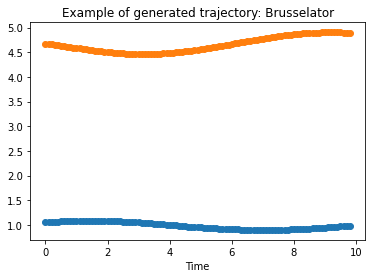

<Figure size 432x288 with 0 Axes>

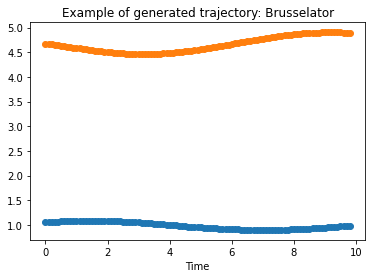

<Figure size 432x288 with 0 Axes>

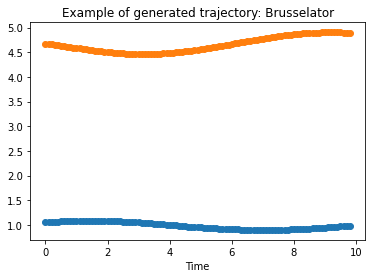

<Figure size 432x288 with 0 Axes>

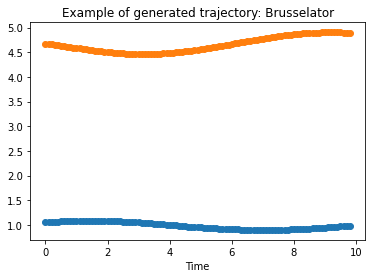

<Figure size 432x288 with 0 Axes>

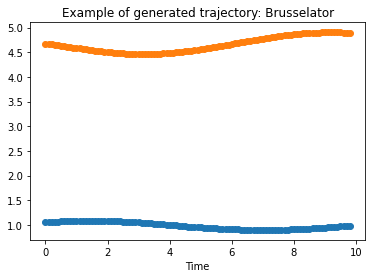

<Figure size 432x288 with 0 Axes>

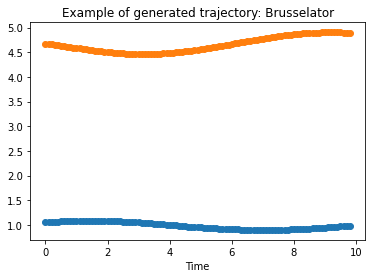

<Figure size 432x288 with 0 Axes>

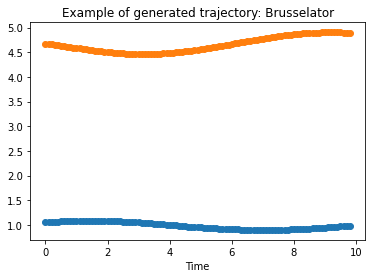

<Figure size 432x288 with 0 Axes>

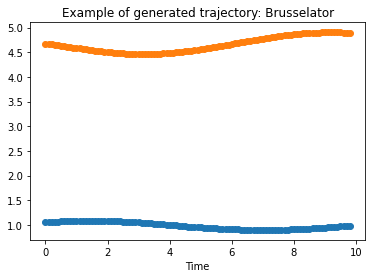

<Figure size 432x288 with 0 Axes>

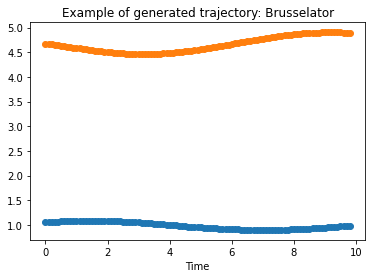

<Figure size 432x288 with 0 Axes>

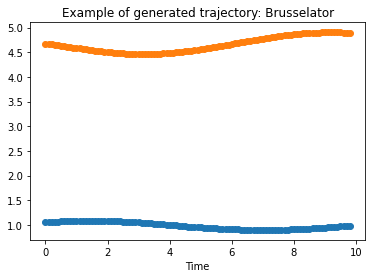

<Figure size 432x288 with 0 Axes>

In [3]:
def Brusselator(T, dt, b=2, a = 1, N_sims=1000, sigma=0, rho=-0.99, random_theta=False):
    N_t  = int(T//dt)
    sims = np.zeros((N_sims, N_t, 2))
    sims[:,0,:] = np.ones((N_sims,2))*np.array([1,b/a])+0.3*np.random.randn(N_sims,2)
    beta = np.ones((N_sims,2))
    beta[:,1] = 0
    tensor = np.zeros((N_sims,2,2))
    tensor[:,0,0] = -(b+1)
    tensor[:,1,0] = b
    cov  = 0*dt * np.array(
            [[sigma**2,       sigma**2 * rho],
             [sigma**2 * rho, sigma**2]])
    dW   = np.random.multivariate_normal([0, 0], cov, size=(N_sims, N_t))
    for i in range(1,N_t):
        tensor[:,0,1] = a*sims[:,i-1,0]**2
        tensor[:,1,1] = -a*sims[:,i-1,0]**2
        sims[:, i, :] = sims[:,i-1,:] + beta*dt + np.einsum('ijk,ik->ij',tensor,sims[:,i-1,:])*dt + sigma*dW[:,i]
    phis = np.zeros((N_sims,N_t, N_t))
    for j in range(0,N_sims):
      for k in range(0,N_t):
        for l in range(0,N_t):
          phis[j,k,l]= np.exp(-0.5*np.linalg.norm(sims[j,k,:]-sims[j,l,:])**2) 
    return sims.astype(np.float32), phis.astype(np.float32)

def BXL_sample(T,dt,N,a,b,sigma,rho,sample_rate,dual_sample_rate, full=True,seed=432):
    '''
    Samples from N 2 dimensional BXL process with opposite means.
    The sample rate should be expressed in samples per unit of time. (on average there will be sample_rate*T sample per series)
    The dual_sample rate gives the proportion of samples wich are jointly sampled (for both dimensions)
    We generate dummy covariates (all 0)
    '''
    np.random.seed(seed)
    y_vec = Brusselator(T, dt=dt, b= b, a = a,N_sims=N, sigma=sigma)[0]
    phis = Brusselator(T, dt=dt, b= b, a = a,N_sims=N, sigma=sigma)[1][0]
    N_t = int(T//dt)
    p_single=1-dual_sample_rate
    p_both=dual_sample_rate
    #col=["ID","Time","Value_1","Value_2","Mask_1","Mask_2","Mask_3","Mask_4","Mask_5","Mask_6","Mask_7","Mask_8","Mask_9","Mask_10","Mask_11","Mask_12","Mask_13","Mask_14","Mask_15","Mask_16","Mask_17","Mask_18","Mask_19","Mask_20","Phi_1","Phi_2","Phi_3","Phi_4","Phi_5","Phi_6","Phi_7","Phi_8","Phi_9","Phi_10","Phi_11","Phi_12","Phi_13","Phi_14","Phi_15","Phi_16","Phi_17","Phi_18","Phi_19","Phi_20","Cov"]

    #col=["ID","Time","Value_1","Value_2","Mask_1","Mask_2","Cov"]
    #col=["ID","Time","Value_1","Value_2","Mask_1","Mask_2","Mask_3","Mask_4","Mask_5","Mask_6","Mask_7","Mask_8","Mask_9","Mask_10","Mask_11","Mask_12","Mask_13","Mask_14","Mask_15","Mask_16","Mask_17","Mask_18","Mask_19","Mask_20","Mask_21","Mask_22","Mask_23","Mask_24","Mask_25","Mask_26","Mask_27","Mask_28","Mask_29","Mask_30","Mask_31","Mask_32","Mask_33","Mask_34","Mask_35","Mask_36","Mask_37","Mask_38","Mask_39","Mask_40","Mask_41","Mask_42","Mask_43","Mask_44","Mask_45","Mask_46","Mask_47","Mask_48","Mask_49","Mask_50","Mask_51","Mask_52","Mask_53","Mask_54","Mask_55","Mask_56","Mask_57","Mask_58","Mask_59","Mask_60","Mask_61","Mask_62","Mask_63","Mask_64","Mask_65","Mask_66","Mask_67","Mask_68","Mask_69","Mask_70","Mask_71","Mask_72","Mask_73","Mask_74","Mask_75","Mask_76","Mask_77","Mask_78","Mask_79","Mask_80","Mask_81","Mask_82","Mask_83","Mask_84","Mask_85","Mask_86","Mask_87","Mask_88","Mask_89","Mask_90","Mask_91","Mask_92","Mask_93","Mask_94","Mask_95","Mask_96","Mask_97","Mask_98","Mask_99","Mask_100","Phi_1","Phi_2","Phi_3","Phi_4","Phi_5","Phi_6","Phi_7","Phi_8","Phi_9","Phi_10","Phi_11","Phi_12","Phi_13","Phi_14","Phi_15","Phi_16","Phi_17","Phi_18","Phi_19","Phi_20","Phi_21","Phi_22","Phi_23","Phi_24","Phi_25","Phi_26","Phi_27","Phi_28","Phi_29","Phi_30","Phi_31","Phi_32","Phi_33","Phi_34","Phi_35","Phi_36","Phi_37","Phi_38","Phi_39","Phi_40","Phi_41","Phi_42","Phi_43","Phi_44","Phi_45","Phi_46","Phi_47","Phi_48","Phi_49","Phi_50","Phi_51","Phi_52","Phi_53","Phi_54","Phi_55","Phi_56","Phi_57","Phi_58","Phi_59","Phi_60","Phi_61","Phi_62","Phi_63","Phi_64","Phi_65","Phi_66","Phi_67","Phi_68","Phi_69","Phi_70","Phi_71","Phi_72","Phi_73","Phi_74","Phi_75","Phi_76","Phi_77","Phi_78","Phi_79","Phi_80","Phi_81","Phi_82","Phi_83","Phi_84","Phi_85","Phi_86","Phi_87","Phi_88","Phi_89","Phi_90","Phi_91","Phi_92","Phi_93","Phi_94","Phi_95","Phi_96","Phi_97","Phi_98","Phi_99","Phi_100","Cov"]
    col=["ID","Time","Value_1","Value_2","Mask_1","Mask_2","Phi_1","Phi_2","Phi_3","Phi_4","Phi_5","Phi_6","Phi_7","Phi_8","Phi_9","Phi_10","Phi_11","Phi_12","Phi_13","Phi_14","Phi_15","Phi_16","Phi_17","Phi_18","Phi_19","Phi_20","Phi_21","Phi_22","Phi_23","Phi_24","Phi_25","Phi_26","Phi_27","Phi_28","Phi_29","Phi_30","Phi_31","Phi_32","Phi_33","Phi_34","Phi_35","Phi_36","Phi_37","Phi_38","Phi_39","Phi_40","Phi_41","Phi_42","Phi_43","Phi_44","Phi_45","Phi_46","Phi_47","Phi_48","Phi_49","Phi_50","Phi_51","Phi_52","Phi_53","Phi_54","Phi_55","Phi_56","Phi_57","Phi_58","Phi_59","Phi_60","Phi_61","Phi_62","Phi_63","Phi_64","Phi_65","Phi_66","Phi_67","Phi_68","Phi_69","Phi_70","Phi_71","Phi_72","Phi_73","Phi_74","Phi_75","Phi_76","Phi_77","Phi_78","Phi_79","Phi_80","Phi_81","Phi_82","Phi_83","Phi_84","Phi_85","Phi_86","Phi_87","Phi_88","Phi_89","Phi_90","Phi_91","Phi_92","Phi_93","Phi_94","Phi_95","Phi_96","Phi_97","Phi_98","Phi_99","Cov"]

    df = pd.DataFrame(columns=col)


    for i in range(N):
        variability_num_samples=0.2 #variability in number of samples for each trajectory.
        #Make sure that there is enough possibilities for sampling the number of observations.
        if variability_num_samples*2*sample_rate*T<1:
            num_samples=int(sample_rate*T)
        elif (sample_rate*dt)==1:
            num_samples = int(sample_rate*T)
        else:
            num_samples=np.random.randint(sample_rate*T*(1-variability_num_samples),sample_rate*T*(1+variability_num_samples)) #number of sample varies around the mean with 20% variability

        lag = 0
        
        if full:
            sample_times = np.arange(N_t)
            sample_type = (np.ones(N_t)*2).astype(np.int)
            num_samples=N_t
        else:
            sample_times=np.random.choice(N_t,num_samples,replace=False)
            sample_type=np.random.choice(3,num_samples,replace=True,p=[p_single/2,p_single/2,p_both])
        samples=y_vec[i,sample_times+lag,:]

        #non observed samples are set to 0
        samples[sample_type==0,1] = 0
        samples[sample_type==1,0] = 0

        #Observed samples have mask 1, others have 0.
        mask=np.ones((num_samples,2))
        mask[sample_type==0,1]=0
        mask[sample_type==1,0]=0

        covs=np.zeros((num_samples,1))
        individual_data=pd.DataFrame(np.concatenate((i*np.ones((num_samples,1)),dt*np.expand_dims(sample_times,1),samples,mask,phis,covs),1),columns=col)

  #      individual_data=pd.DataFrame(np.concatenate((i*np.ones((num_samples,1)),dt*np.expand_dims(sample_times,1),samples,mask,covs),1),columns=col)
        df=df.append(individual_data)
    df.reset_index(drop=True,inplace=True)
    return(df)

if __name__=="__main__":
    parser = argparse.ArgumentParser(description="Generating 2D Brusselator datasets.")
    parser.add_argument('--rho', type=float, help="Correlation between the two variables.", default=0.99)
    parser.add_argument('--prefix', type=str, help="Prefix for generated data", default="BXLator")

    args, unknown = parser.parse_known_args()

    T       = 10
    delta_t = 0.1
    a       = 0.3
    b       = 1.4
    sigma   = 0
    rho = args.rho
    sample_rate = 0.5
    dual_sample_rate = 0.8

    N  = 1
    df = BXL_sample(T = T, dt = delta_t,
                N = N, sigma = sigma, a = a, b= b,
                rho = rho, sample_rate = sample_rate,
                dual_sample_rate = dual_sample_rate)
    df.to_csv(f"{args.prefix}.csv",index=False)

    #Save metadata dictionary
    metadata_dict = {"T":T, "delta_t":delta_t, "rho": args.rho,
                    "sample_rate": sample_rate, "dual_sample_rate": dual_sample_rate,
                    "sigma":sigma, "a" : a, "b": b}
    np.save(f"{args.prefix}_metadata.npy",metadata_dict)

    #Plot some examples and store them.
    import os
    N_examples = 10
    examples_dir = f"{args.prefix}_paths_examples/"
    if not os.path.exists(examples_dir):
        os.makedirs(examples_dir)
    for ex in range(N_examples):
        idx = np.random.randint(low=0,high=df["ID"].nunique())
        plt.figure()
        for dim in range(2):
            random_sample = df.loc[df["ID"]==idx].sort_values(by="Time").values
            obs_mask = random_sample[:,4+dim]==1
            plt.scatter(random_sample[obs_mask,1],random_sample[obs_mask,2+dim])
            plt.title("Example of generated trajectory: Brusselator")
            plt.xlabel("Time")
        plt.show()
        plt.savefig(f"full_example_{ex}.pdf")

Here we plot both the true data and attempted 'recoveries' of the data with kPCA using various kernels:

In [10]:
#generate one simulation of Brusselator with no noise
bx=Brusselator(T=10, dt=0.1, b=2, a = 1, N_sims=1, sigma=0.0, rho=-0.0, random_theta=False)

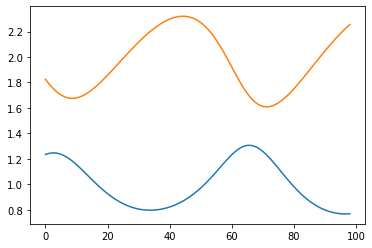

In [17]:
plt.plot(bx[0][0])

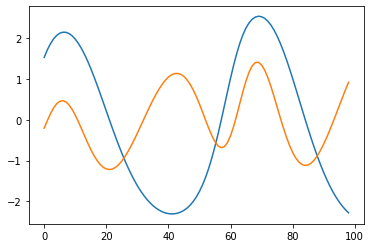

In [53]:
#Implement KPCA with linear kernel
import sklearn
from sklearn.decomposition import KernelPCA
KPCA=sklearn.decomposition.KernelPCA(n_components=2, kernel='poly', degree=2,gamma=0.2, kernel_params=None, alpha=-0.4, coef0= 0, fit_inverse_transform=False, eigen_solver='auto', tol=0, max_iter=None, remove_zero_eig=False, random_state=None, copy_X=True, n_jobs=None)
Transform=KPCA.fit_transform(bx[1][0])
plt.plot(Transform)

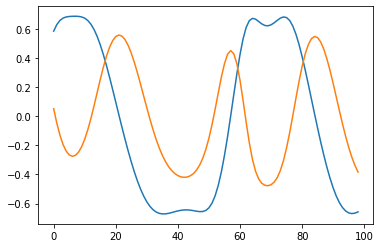

In [29]:
#with rbf kernel
import sklearn
from sklearn.decomposition import KernelPCA
KPCA=sklearn.decomposition.KernelPCA(n_components=2, kernel='rbf', degree=3,gamma=1, kernel_params=None, alpha=-0.1, coef0= 0, fit_inverse_transform=False, eigen_solver='auto', tol=0, max_iter=None, remove_zero_eig=False, random_state=None, copy_X=True, n_jobs=None)
Transform=KPCA.fit_transform(bx[1][0])
plt.plot(Transform)

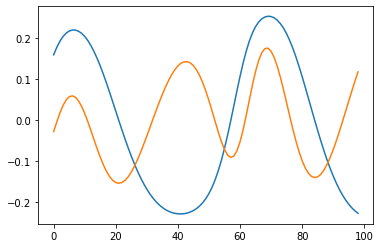

In [24]:
#with poly kernel
import sklearn
from sklearn.decomposition import KernelPCA
KPCA=sklearn.decomposition.KernelPCA(n_components=2, kernel='poly', degree=3,gamma=0.015, kernel_params=None, alpha=-0.1, coef0= 0, fit_inverse_transform=False, eigen_solver='auto', tol=0, max_iter=None, remove_zero_eig=False, random_state=None, copy_X=True, n_jobs=None)
Transform=KPCA.fit_transform(bx[1][0])
plt.plot(Transform)

In [ ]:
df

,ID,Time,Value_1,Value_2,Mask_1,Mask_2,Phi_1,Phi_2,Phi_3,Phi_4,Phi_5,Phi_6,Phi_7,Phi_8,Phi_9,Phi_10,Phi_11,Phi_12,Phi_13,Phi_14,Phi_15,Phi_16,Phi_17,Phi_18,Phi_19,Phi_20,Phi_21,Phi_22,Phi_23,Phi_24,Phi_25,Phi_26,Phi_27,Phi_28,Phi_29,Phi_30,Phi_31,Phi_32,Phi_33,Phi_34,...,Phi_61,Phi_62,Phi_63,Phi_64,Phi_65,Phi_66,Phi_67,Phi_68,Phi_69,Phi_70,Phi_71,Phi_72,Phi_73,Phi_74,Phi_75,Phi_76,Phi_77,Phi_78,Phi_79,Phi_80,Phi_81,Phi_82,Phi_83,Phi_84,Phi_85,Phi_86,Phi_87,Phi_88,Phi_89,Phi_90,Phi_91,Phi_92,Phi_93,Phi_94,Phi_95,Phi_96,Phi_97,Phi_98,Phi_99,Cov
0,0.0,0.0,1.056063,4.677016,1.0,1.0,1.000000,0.999466,0.997881,0.995277,0.991690,0.987162,0.981737,0.975461,0.968385,0.960560,0.952039,0.942878,0.933131,0.922854,0.912106,0.900941,0.889417,0.877590,0.865514,0.853246,0.840837,0.828341,0.815809,0.803288,0.790829,0.778475,0.766273,0.754263,0.742487,0.730984,0.719791,0.708943,0.698474,0.688416,...,0.667980,0.679133,0.691039,0.703586,0.716624,0.729964,0.743371,0.756559,0.769188,0.780871,0.791171,0.799617,0.805723,0.809007,0.809032,0.805438,0.797987,0.786602,0.771394,0.752686,0.731004,0.707058,0.681696,0.655840,0.630427,0.606342,0.584367,0.565148,0.549178,0.536797,0.528205,0.523479,0.522597,0.525453,0.531871,0.541623,0.554434,0.569991,0.587948,0.0
1,0.0,0.1,1.059092,4.668381,1.0,1.0,0.999466,1.000000,0.999474,0.997914,0.995352,0.991826,0.987377,0.982049,0.975888,0.968945,0.961271,0.952918,0.943942,0.934397,0.924339,0.913825,0.902911,0.891653,0.880108,0.868329,0.856372,0.844289,0.832133,0.819954,0.807801,0.795722,0.783761,0.771964,0.760373,0.749028,0.737968,0.727230,0.716849,0.706860,...,0.683541,0.694254,0.705651,0.717608,0.729967,0.742526,0.755041,0.767215,0.778703,0.789109,0.797996,0.804898,0.809335,0.810845,0.809013,0.803511,0.794137,0.780856,0.763824,0.743403,0.720158,0.694824,0.668264,0.641404,0.615173,0.590436,0.567949,0.548329,0.532037,0.519387,0.510553,0.505598,0.504485,0.507102,0.513277,0.522785,0.535359,0.550698,0.568471,0.0
2,0.0,0.2,1.062002,4.659561,1.0,1.0,0.997881,0.999474,1.000000,0.999482,0.997948,0.995431,0.991968,0.987600,0.982372,0.976331,0.969525,0.962006,0.953827,0.945042,0.935706,0.925875,0.915604,0.904950,0.893969,0.882715,0.871245,0.859611,0.847867,0.836064,0.824252,0.812481,0.800796,0.789244,0.777869,0.766712,0.755815,0.745215,0.734950,0.725055,...,0.698950,0.709202,0.720067,0.731411,0.743065,0.754819,0.766416,0.777553,0.787877,0.796987,0.804448,0.809797,0.812565,0.812308,0.808635,0.801251,0.789991,0.774861,0.756059,0.733989,0.709247,0.682594,0.654906,0.627110,0.600122,0.574789,0.551839,0.531858,0.515278,0.502383,0.493327,0.488151,0.486811,0.489187,0.495107,0.504352,0.516664,0.531753,0.549302,0.0
3,0.0,0.3,1.064780,4.650583,1.0,1.0,0.995277,0.997914,0.999482,1.000000,0.999491,0.997984,0.995512,0.992114,0.987831,0.982706,0.976787,0.970122,0.962764,0.954764,0.946177,0.937057,0.927459,0.917440,0.907055,0.896360,0.885409,0.874258,0.862959,0.851565,0.840128,0.828697,0.817321,0.806046,0.794917,0.783979,0.773273,0.762839,0.752715,0.742940,...,0.714158,0.723929,0.734240,0.744948,0.755874,0.766799,0.777457,0.787536,0.796677,0.804477,0.810501,0.814292,0.815395,0.813382,0.807890,0.798654,0.785549,0.768620,0.748108,0.724453,0.698284,0.670383,0.641636,0.612971,0.585290,0.559416,0.536052,0.515751,0.498915,0.485802,0.476541,0.471157,0.469594,0.471729,0.477387,0.486355,0.498383,0.513194,0.530483,0.0
4,0.0,0.4,1.067412,4.641474,1.0,1.0,0.991690,0.995352,0.997948,0.999491,1.000000,0.999500,0.998021,0.995597,0.992265,0.988068,0.983049,0.977256,0.970737,0.963543,0.955728,0.947344,0.938447,0.929090,0.919331,0.909224,0.898824,0.888186,0.877364,0.866412,0.855381,0.844322,0.833284,0.822316,0.811464,0.800774,0.790287,0.780046,0.770091,0.760460,...,0.729117,0.738388,0.748125,0.758177,0.768354,0.778429,0.788127,0.797130,0.805072,0.811551,0.816132,0.818366,0.817810,0.814058,0.806771,0.795720,0.780814,0.762140,0.739978,0.714806,0.687280,0.658203,0.628469,0.599001,0.570688,0.544329,0.520598,0.500018,0.482960,0.469653,0.460207,0.454629,0.452850,0.45

# GRU-ODE-Bayes



In [ ]:
parser = argparse.ArgumentParser(description="Running GRUODE on Double OU")
parser.add_argument('--model_name', type=str, help="Model to use", default="BXLator")
parser.add_argument('--dataset', type=str, help="Dataset CSV file", default="../../gru_ode_bayes/datasets/BXLator/BXLator.csv")
parser.add_argument('--mixing', type=float, help="Mixing multiplier", default=1e-4)
parser.add_argument('--seed', type=int, help="Seed for data split generation", default=432)
parser.add_argument('--solver', type=str, choices=["euler", "midpoint","dopri5"], default="euler")
parser.add_argument('--no_impute',action="store_true",default = True)
parser.add_argument('--demo',action="store_true",default = False)

args, unknown = parser.parse_known_args()

model_name = args.model_name
params_dict=dict()

device  = torch.device("cuda")
N       = 1000
delta_t = 0.05
T       = 50
train_idx, val_idx = train_test_split(np.arange(N),test_size=0.2, random_state=args.seed)
val_options = {"T_val": 4, "max_val_samples": 3}
#data_train = data_utils.ODE_Dataset(csv_file=args.dataset, idx=train_idx)
#data_val   = data_utils.ODE_Dataset(csv_file=args.dataset, idx=val_idx,validation = True, val_options = val_options )
data_train = ODE_Dataset(panda_df=df, idx=train_idx)
data_val   = ODE_Dataset(panda_df=df, idx=val_idx,validation = True, val_options = val_options )
#Dataset metadata
metadata = metadata

#Model parameters.
params_dict["input_size"]  = 99
params_dict["hidden_size"] = 50
params_dict["p_hidden"]    = 25
params_dict["prep_hidden"] = 25
params_dict["logvar"]      = True
params_dict["mixing"]      = args.mixing
params_dict["delta_t"]     = delta_t
params_dict["dataset"]     = args.dataset
params_dict["jitter"]      = 0
params_dict["gru_bayes"]   = "masked_mlp"
params_dict["full_gru_ode"] = True
params_dict["solver"]      = args.solver
params_dict["impute"]      = args.no_impute

params_dict["T"]           = T

#Model parameters and the metadata of the dataset used to train the model are stored as a single dictionnary.
#summary_dict ={"model_params":params_dict,"metadata":metadata}
#np.save(f"./../trained_models/{model_name}_params.npy",summary_dict)

dl     = DataLoader(dataset=data_train, collate_fn=custom_collate_fn, shuffle=True, batch_size=100,num_workers=2)
dl_val = DataLoader(dataset=data_val, collate_fn=custom_collate_fn, shuffle=False, batch_size = len(data_val),num_workers=2)


## the neural negative feedback with observation jumps
model = NNFOwithBayesianJumps(input_size = params_dict["input_size"], hidden_size = params_dict["hidden_size"],
                                        p_hidden = params_dict["p_hidden"], prep_hidden = params_dict["prep_hidden"],
                                        logvar = params_dict["logvar"], mixing = params_dict["mixing"],
                                        full_gru_ode = params_dict["full_gru_ode"],
                                        solver = params_dict["solver"], impute = params_dict["impute"])
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
epoch_max = 200

#params_dict=dict()

#Training
for epoch in range(epoch_max):
    model.train()
    optimizer.zero_grad()
    for i, b in tqdm.tqdm(enumerate(dl)):
        times    = b["times"]
        time_ptr = b["time_ptr"]
        X        = b["X"].to(device)
        Phi        = b["Phi"].to(device)
        M        = b["M"].to(device)
        obs_idx  = b["obs_idx"].to(device)
        cov      = b["cov"].to(device)

        y = b["y"]
        hT, loss, _, _  = model(times, time_ptr, X.cuda(),Phi.cuda(), M.cuda(), obs_idx.cuda(), delta_t=delta_t, T=T, cov=cov.cuda())

        loss.backward()
        if i%10==0:
            optimizer.step()
            optimizer.zero_grad()

    with torch.no_grad():
        mse_val  = 0
        loss_val = 0
        num_obs  = 0
        model.eval()
        for i, b in enumerate(dl_val):
            times    = b["times"]
            time_ptr = b["time_ptr"]
            X        = b["X"].to(device)
            M        = b["M"].to(device)
            Phi       = b["Phi"].to(device)
            obs_idx  = b["obs_idx"].to(device)
            cov      = b["cov"].to(device)

            X_val     = b["X_val"].to(device)
            M_val     = b["M_val"].to(device)
            Phi_val        = b["Phi_val"].to(device)

            times_val = b["times_val"]
            times_idx = b["index_val"]

            y = b["y"]

            hT, loss, _, t_vec, p_vec, h_vec, eval_times,_ = model(times, time_ptr, X.cuda(),Phi.cuda(), M.cuda(), obs_idx.cuda(), delta_t=delta_t, T=T, cov=cov.cuda(), return_path=True)
            t_vec = np.around(t_vec,str(delta_t)[::-1].find('.')).astype(np.float32) #Round floating points error in the time vector.

            p_val     = extract_from_path(t_vec,p_vec,times_val,times_idx)
            m, v      = torch.chunk(p_val,2,dim=1)
            KPCA=sklearn.decomposition.KernelPCA(n_components=2, kernel='poly', gamma=2, kernel_params=None, alpha=1.0, fit_inverse_transform=True, eigen_solver='auto', tol=0, max_iter=None, remove_zero_eig=False, random_state=None, copy_X=True, n_jobs=None)
            m= torch.from_numpy(KPCA.fit_transform(m.cpu().detach().numpy())).cuda()
            v= torch.from_numpy(KPCA.fit_transform(v.cpu().detach().numpy())).cuda()
            
            last_loss = (log_lik_gaussian(X_val,m,v)*M_val).sum()
            mse_loss  = (torch.pow(X_val - m, 2) * M_val).sum()

            loss_val += last_loss.cpu().numpy()
            mse_val  += mse_loss.cpu().numpy()
            num_obs  += M_val.sum().cpu().numpy()
            #list1.append(loss_val/1000)
            #list2.append(mse_val/1000)

        loss_val /= num_obs
        mse_val  /= num_obs
        
        print(f"Mean validation loss at epoch {epoch}: nll={loss_val:.5f}, mse={mse_val:.5f}  (num_obs={num_obs})")

print(f"Last validation log likelihood : {loss_val}")
print(f"Last validation MSE : {mse_val}")




0it [00:00, ?it/s]


1it [00:02,  2.93s/it]


2it [00:05,  2.88s/it]


3it [00:08,  2.80s/it]


4it [00:10,  2.77s/it]


5it [00:13,  2.68s/it]


6it [00:16,  2.66s/it]


7it [00:18,  2.57s/it]


8it [00:21,  2.64s/it]


Mean validation loss at epoch 0: nll=8.18611, mse=11.29818  (num_obs=1200.0)





0it [00:00, ?it/s]


1it [00:02,  2.97s/it]


2it [00:05,  2.87s/it]


3it [00:08,  2.88s/it]


4it [00:10,  2.75s/it]


5it [00:13,  2.71s/it]


6it [00:16,  2.66s/it]


7it [00:18,  2.56s/it]


8it [00:21,  2.65s/it]


Mean validation loss at epoch 1: nll=17.88142, mse=13.84578  (num_obs=1200.0)





0it [00:00, ?it/s]


1it [00:03,  3.19s/it]


2it [00:05,  3.04s/it]


3it [00:08,  2.93s/it]


4it [00:11,  2.83s/it]


5it [00:13,  2.70s/it]


6it [00:16,  2.69s/it]


7it [00:18,  2.64s/it]


8it [00:21,  2.66s/it]


Mean validation loss at epoch 2: nll=20.30980, mse=14.48484  (num_obs=1200.0)





0it [00:00, ?it/s]


1it [00:03,  3.11s/it]


2it [00:05,  2.96s/it]


3it [00:08,  2.81s/it]


4it [00:10,  2.73s/it]


5it [00:12,  2.54s/it]


6it [00:15,  2.50s/it]


7it [00:17,  2.50s/it]


8it [00:20,  2.52s/it]
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_kernel_pca.py:262: LinAlgWarning: Ill-conditioned matrix (rcond=4.37468e-08): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, sym_pos=True, overwrite_a=True)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_kernel_pca.py:262: LinAlgWarning: Ill-conditioned matrix (rcond=4.37468e-08): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, sym_pos=True, overwrite_a=True)


Mean validation loss at epoch 3: nll=19.33658, mse=13.99346  (num_obs=1200.0)





0it [00:00, ?it/s]


1it [00:02,  2.98s/it]


2it [00:05,  2.87s/it]

KeyboardInterrupt: ignored

In [ ]:
style = "fill"
metadata={}
max_lag = 0
metadata["T"]=50
metadata["delta_t"]=0.1
metadata["rho"]=0.99
metadata["sample_rate"]=0.5
metadata["dual_sample_rate"]=0.8
metadata["sigma"]=0.1
metadata["a"]=0.3
metadata["b"]=1.4
#Model parameters.
params_dict={}
params_dict["input_size"]  = 2
params_dict["hidden_size"] = 100
params_dict["p_hidden"]    = 25
params_dict["prep_hidden"] = 25
params_dict["logvar"]      = True
params_dict["mixing"]      = 1e-4
params_dict["delta_t"]     = delta_t
params_dict["dataset"]     = args.dataset
params_dict["jitter"]      = 0
params_dict["gru_bayes"]   = "masked_mlp"
params_dict["full_gru_ode"] = True
#params_dict["solver"]      = args.solver
params_dict["solver"]="euler"
params_dict["impute"]      = not args.no_impute
params_dict["T"]           = T

if type(params_dict) == np.ndarray:
## converting np array to dictionary:
        params_dict = params_dict.tolist()
model.eval()

    #Test data :
N           = 10
T           = metadata["T"]
delta_t     = metadata["delta_t"]
theta       = metadata.pop("theta",None)
sigma       = metadata["sigma"]
rho         = metadata["rho"]
r_mu        = metadata.pop("r_mu",None)
sample_rate = metadata["sample_rate"]
sample_rate = 1
dual_sample_rate = metadata["dual_sample_rate"]
r_std       = metadata.pop("r_std",None)
max_lag     = 0

df = datagen.BXL_sample(T = metadata["T"], dt = metadata["delta_t"],N = N, sigma = metadata["sigma"], a = 0.3, b= 1.4, rho = metadata["rho"], sample_rate = 10 , dual_sample_rate = 1, full = True)

        ## for 10 time-points
times_1 = [2.0,5.0, 12.0,15.0, 23.0, 32.0,35.0, 41.0, 43.0]
times_2 = [1.0,7.0, 12.0, 15.0, 25.0, 32.0, 38.0, 45.0]


times   = np.union1d(times_1,times_2)
obs     = df.loc[df["Time"].isin(times)].copy()
obs[["Mask_1","Mask_2"]]                   = 0
obs.loc[df["Time"].isin(times_1),"Mask_1"] = 1
obs.loc[df["Time"].isin(times_2),"Mask_2"] = 1


data = data_utils.ODE_Dataset(panda_df=obs, jitter_time=0)
dl   = DataLoader(dataset=data, collate_fn=data_utils.custom_collate_fn, shuffle=False, batch_size=1)
with torch.no_grad():
    for sample, b in enumerate(dl):
            times    = b["times"]
            time_ptr = b["time_ptr"]
            X        = b["X"]
            M        = b["M"]
            obs_idx  = b["obs_idx"]
            cov      = b["cov"]
            y = b["y"]
            hT, loss, _, t_vec, p_vec, _, eval_times, eval_vals = model(times, time_ptr, X.cuda(), M.cuda(), obs_idx.cuda(), delta_t=delta_t, T=T, cov = cov.cuda(), return_path=True)

            if params_dict["solver"]=="dopri5":
                p_vec = eval_vals
                t_vec = eval_times.cpu().numpy()
            
            observations=X.detach().numpy()
            m, v = torch.chunk(p_vec[:,0,:],2,dim=1)

            if params_dict["logvar"]:
                up   = m + torch.exp(0.5*v) * 1.96
                down = m - torch.exp(0.5*v) * 1.96
            else:
                up   = m + torch.sqrt(v) * 1.96
                down = m - torch.sqrt(v) * 1.96

            plots_dict = dict()
            plots_dict["t_vec"] = t_vec
            up=up.cpu()
            plots_dict["up"] = up.numpy()
            down=down.cpu()
            plots_dict["down"] = down.numpy() 
            m=m.cpu()          
            plots_dict["m"] = m.numpy()
            plots_dict["observations"] = observations
            plots_dict["mask"] = M.cpu().numpy()

            fill_colors = [cm.Blues(0.25), cm.Greens(0.25)]

            line_colors = [cm.Blues(0.6), cm.Greens(0.6)]
            colors=["blue","green"]

            ## sde trajectory
            df_i = df.query(f"ID == {sample}")
            plt.figure(figsize=(6.4, 4.8))
            if style == "fill":
                for dim in range(2):
                  plt.fill_between(x  = t_vec,y1 = down[:,dim].numpy(),y2 = up[:,dim].numpy(),facecolor = fill_colors[dim],alpha=1.0, zorder=1)
                  plt.plot(t_vec, m[:,dim].numpy(), color=line_colors[dim], linewidth=2, zorder=2, label=f"Dimension {dim+1}")
                  observed_idx = np.where(plots_dict["mask"][:, dim]==1)[0]
                  plt.scatter(times[observed_idx], observations[observed_idx,dim], color=colors[dim], alpha=0.5, s=60)
                  plt.plot(df_i.Time, df_i[f"Value_{dim+1}"], ":", color=colors[dim], linewidth=1.5, alpha=0.8)
            else:
                for dim in range(2):
                  plt.figure()
                  plt.plot(t_vec, up[:,dim].numpy(),"--", color="red", linewidth=2)
                  plt.plot(t_vec, down[:,dim].numpy(),"--", color="red",linewidth=2)
                  plt.plot(t_vec, m[:,dim].numpy(), color=colors[dim], linewidth=2)
                  observed_idx = np.where(plots_dict["mask"][:, dim]==1)[0]
                  plt.scatter(times[observed_idx], observations[observed_idx,dim], color=colors[dim], alpha=0.5, s=60)
                  plt.plot(df_i.Time, df_i[f"Value_{dim+1}"], ":", color=colors[dim], linewidth=1.5, alpha=0.8)

            plt.title("Test trajectory of a Brusselator process")
            plt.xlabel("Time")
            plt.grid()
            plt.legend(loc="lower right")
            plt.ylabel("Predicton (+/- 1.96 st. dev)")
            plt.show()
            plt.tight_layout()